In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input
import numpy as np
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports MDN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Set up environment.
# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


Loaded perfs: 1626 and 1626
Num touches: 249870


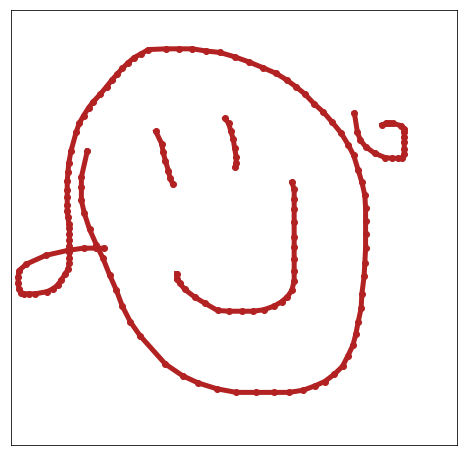

In [132]:
### Loading from the saved datasets.
with np.load('../datasets/tiny_performance_datasets.npz') as loaded:
    loaded_raw = loaded['raw_perfs']
    loaded_diff = loaded['diff_perfs']
    
print("Loaded perfs:", len(loaded_raw), "and", len(loaded_diff))
print("Num touches:", np.sum([len(l) for l in loaded_raw]))

corpus = []

for l in loaded_raw:
    corpus.append(l[:,:-1])
    
    
# Plot a bit of the data to have a look:
choice = 20

input_perf = corpus[choice]

robojam.plot_2D(robojam.perf_array_to_df(input_perf))

In [2]:
# Decoding Model

# Model Hyperparameters
SEQ_LEN = 1
HIDDEN_UNITS = 512
N_LAYERS = 2
NUMBER_MIXTURES = 5
TIME_DIST = False

decoder = robojam.build_robojam_model(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=N_LAYERS, time_dist=TIME_DIST, inference=True, compile_model=False, print_summary=True)
#decoder.load_weights("../robojam-model-layers2-units512-mixtures5-scale10-E13-VL-5.79.hdf5")
decoder.load_weights("../models/robojam-metatone-layers2-units512-mixtures5-scale10-E30-VL-5.65.hdf5")

Building RoboJam Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (1, 1, 3)                 0         
_________________________________________________________________
lstm0 (LSTM)                 (1, 1, 512)               1056768   
_________________________________________________________________
lstm1 (LSTM)                 (1, 512)                  2099200   
_________________________________________________________________
mdn_outputs (MDN)            (1, 35)                   17955     
Total params: 3,173,923
Trainable params: 3,173,923
Non-trainable params: 0
_________________________________________________________________


sig temps:  [0.0, 0.001, 0.01, 0.1, 0.5, 1.0]
pi temps:  [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]


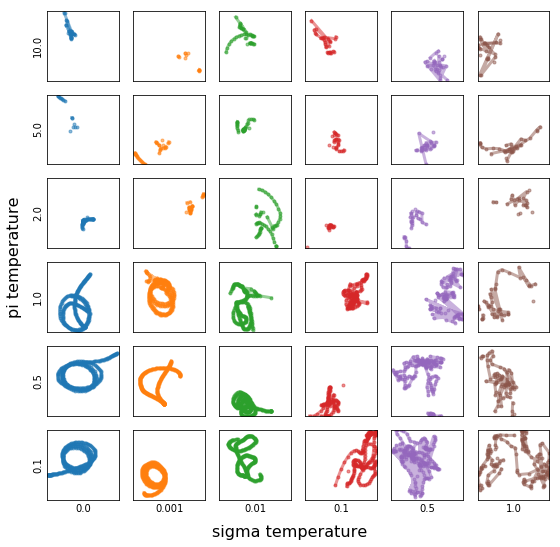

In [135]:
sig_temps = [0., 1e-3, 1e-2, 1e-1, 5e-1, 1e-0]
pi_temps = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
colors = plt.get_cmap('tab10').colors
#colors = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

print("sig temps: ",sig_temps)
print("pi temps: ", pi_temps)

def plot_perf_on_ax(perf_df, ax, color="#ec0205"):
    """Plot a 2D representation of a performance 2D"""
    swipes = robojam.divide_performance_into_swipes(perf_df)
    for swipe in swipes:
        p = ax.plot(swipe.x, swipe.y, 'o-', alpha=0.5, markersize=3)
        plt.setp(p, color=color, linewidth=3)
    ax.set_ylim([1.0,0])
    ax.set_xlim([0,1.0])
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_perf_to_plot(pi_temp, sig_temp):
    decoder.reset_states()
    t = robojam.random_touch()
    p = robojam.generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=pi_temp, sigma_temp=sig_temp)
    return robojam.perf_array_to_df(p)

fig, axes = plt.subplots(6, 6, figsize=(9,9))

for i in range(6):
    for j in range(6):
        c = colors[j] #plt.get_cmap(colors[j])(0.8*(5-i)/5 + 0.2)
        plot_perf_on_ax(get_perf_to_plot(pi_temps[i],sig_temps[j]), axes[5-i,j], color=c)


# axes (5-y,x)
# y is pi_temps
# x is sig_temps
        
for i in range(6):
    axes[5-i, 0].set_ylabel(str(pi_temps[i]))
    axes[5, i].set_xlabel(str(sig_temps[i]))
    
fig.text(0.5, 0.075, 'sigma temperature', fontsize=16, ha='center', va='center')
fig.text(0.075, 0.5, 'pi temperature', fontsize=16, ha='center', va='center', rotation='vertical')

fig.savefig("robojam_temperature_sampling.png", dpi=300, bbox_inches='tight')

sig temps:  [0.0, 0.001, 0.01, 0.1, 0.5, 1.0]
pi temps:  [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]


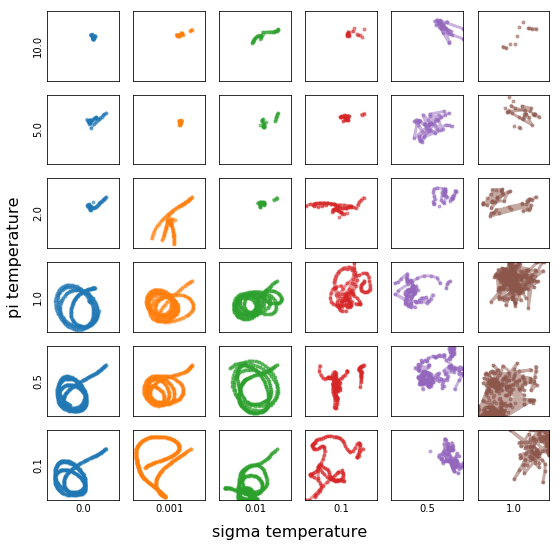

In [133]:
# Conditioned version.

sig_temps = [0., 1e-3, 1e-2, 1e-1, 5e-1, 1e-0]
pi_temps = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
colors = plt.get_cmap('tab10').colors
#colors = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

print("sig temps: ",sig_temps)
print("pi temps: ", pi_temps)
    
def get_perf_to_plot_conditioned(pi_temp, sig_temp, input_perf):
    decoder.reset_states()
    t = robojam.random_touch()
    p = robojam.condition_and_generate(decoder, input_perf, NUMBER_MIXTURES, temp=pi_temp, sigma_temp=sig_temp)
    return robojam.perf_array_to_df(p)

fig, axes = plt.subplots(6, 6, figsize=(9,9))

for i in range(6):
    for j in range(6):
        c = colors[j] #plt.get_cmap(colors[j])(0.8*(5-i)/5 + 0.2)
        perf = get_perf_to_plot_conditioned(pi_temps[i],sig_temps[j], input_perf)
        plot_perf_on_ax(perf, axes[5-i,j], color=c)

# axes (5-y,x)
# y is pi_temps
# x is sig_temps
        
for i in range(6):
    axes[5-i, 0].set_ylabel(str(pi_temps[i]))
    axes[5, i].set_xlabel(str(sig_temps[i]))
    
fig.text(0.5, 0.075, 'sigma temperature', fontsize=16, ha='center', va='center')
fig.text(0.075, 0.5, 'pi temperature', fontsize=16, ha='center', va='center', rotation='vertical')

fig.savefig("robojam_temperature_sampling_cond.png", dpi=300, bbox_inches='tight')